In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0")
if torch.cuda.is_available:
  device = torch.device("cuda:0")
  print("running on a GPU")
else:
  device = torch.device("cpu")
  print("running on a cpu")

running on a GPU


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/MyDrive/PetImages"

Cat  Dog


In [ ]:
!pip install tqdm
!pip install matplotlib
!pip install numpy
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


REBUILD_DATA = True ### After the code is run once, this can be turned to False


class DogsVSCats:
    IMG_SIZE = 50
    CATS = './gdrive/MyDrive/PetImages/Cat'
    DOGS = './gdrive/MyDrive/PetImages/Dog'
    LABELS = {
        CATS: 0,
        DOGS: 1
    }
    training_data = []
    cat_count = 0
    dog_count = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.CATS:
                            self.cat_count += 1
                        elif label == self.DOGS:
                            self.dog_count += 1
                    except Exception as e:
                        pass
                        # print(str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.cat_count)
        print("Dogs:", self.dog_count)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

training_data = np.load("training_data.npy", allow_pickle=True)

net = Net().to(device)

optimiser = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)


train_X = X[:-val_size]
test_X = X[-val_size:]

train_y = y[:-val_size]
test_y = y[-val_size:]

BATCH_SIZE = 100
EPOCHS = 10

def train():
  for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
          batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
          batch_y = train_y[i:i+BATCH_SIZE].to(device)

          net.zero_grad()
          outputs = net(batch_X)
          loss = loss_function(outputs, batch_y)
          loss.backward()
          optimiser.step()
      print(f"Epoch: {epoch}, Loss : {loss}")


def test():
  correct = 0
  total = 0
  with torch.no_grad():
      for i in tqdm(range(len(test_X))):
          real_class = torch.argmax(test_y[i]).to(device)
          net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
          predicted_class = torch.argmax(net_out)
          if predicted_class == real_class:
              correct += 1
          total += 1
  print("Accuracy:", round(correct/total, 3))

train()
test()

./gdrive/MyDrive/PetImages/Cat


100%|██████████| 12501/12501 [02:04<00:00, 100.51it/s]


./gdrive/MyDrive/PetImages/Dog


100%|██████████| 12501/12501 [00:50<00:00, 247.92it/s]
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Cats: 12476
Dogs: 12470


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
100%|██████████| 225/225 [00:02<00:00, 78.05it/s] 


Epoch: 0, Loss : 0.2431633323431015


100%|██████████| 225/225 [00:02<00:00, 106.59it/s]


Epoch: 1, Loss : 0.22779108583927155


100%|██████████| 225/225 [00:02<00:00, 106.36it/s]


Epoch: 2, Loss : 0.18690946698188782


100%|██████████| 225/225 [00:02<00:00, 106.16it/s]


Epoch: 3, Loss : 0.16783758997917175


100%|██████████| 225/225 [00:02<00:00, 106.16it/s]


Epoch: 4, Loss : 0.13850432634353638


100%|██████████| 225/225 [00:02<00:00, 106.15it/s]


Epoch: 5, Loss : 0.12714633345603943


100%|██████████| 225/225 [00:02<00:00, 106.16it/s]


Epoch: 6, Loss : 0.10772469639778137


100%|██████████| 225/225 [00:02<00:00, 106.07it/s]


Epoch: 7, Loss : 0.11626346409320831


100%|██████████| 225/225 [00:02<00:00, 105.99it/s]


Epoch: 8, Loss : 0.10263043642044067


100%|██████████| 225/225 [00:02<00:00, 105.76it/s]


Epoch: 9, Loss : 0.08843754231929779


100%|██████████| 2494/2494 [00:01<00:00, 1254.79it/s]

Accuracy: 0.739


In [ ]:
def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs,y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimiser.step()
  return acc, loss
  

In [ ]:
def test(size=32):
  random_start = np.random.randint(len(test_X)-size)
  X, y = test_X[random_start:random_start+size], test_y[random_start: random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

0.77 tensor(0.1590, device='cuda:0')


In [ ]:
import time

MODEL_NAME =  f"model-{int(time.time())}"

net = Net().to(device)
optimiser = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
  BATCH_SIZE = 100
  EPOCHS = 5
  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        if i % 50 == 0:
          val_acc, val_loss = test(size=100)
          f.write(f'{MODEL_NAME},{round(time.time(), 3)}, {round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n')
train()

model-1653378639


100%|██████████| 225/225 [00:04<00:00, 50.31it/s]


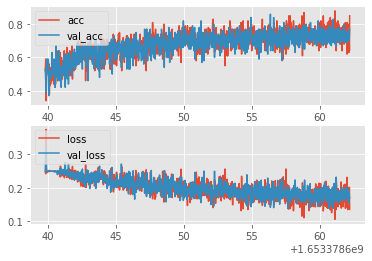

In [ ]:
from matplotlib import style
# %matplotlib inline

style.use("ggplot")

model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accuracies = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

      times.append(float(timestamp))
      accuracies.append(float(acc))
      losses.append(float(loss))

      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))

  fig = plt.figure()
  
  ax1 = plt.subplot2grid((2, 1), (0, 0))
  ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

  ax1.plot(times, accuracies, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()
  
create_acc_loss_graph(model_name)

In [ ]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2022.5.18.1
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
di